In [1]:
import os 
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

import matplotlib.pyplot as plt 

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from glob import glob
from PIL import Image

In [2]:
#
# My Unet implementation using pytorch
#
# Ref: https://arxiv.org/pdf/1505.04597.pdf
#

class Unet(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(Unet, self).__init__()
        
        self.in_channels = in_channels
        self.n_classes = n_classes
                
        # UNET construction
        #
                
        # input in_channels -> 64
        self.inc = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # max pooling 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # by default: kernel_size => stride size
        
        # down 64 -> 128
        self.down1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        # max pooling 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # down 128 -> 256
        self.down2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        # max pooling 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # down 256 -> 512
        self.down3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        # max pooling 4
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
                
        # down 512 => 1024 
        # at the bottom of the Unet architecture
        self.bottom = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )

        # conv transpose 3 1024 => 512
        self.transpose3 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
        
        # up3    1024 => 512
        self.up3 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        # conv transpose 2 512 => 256
        self.transpose2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        
        # up2    512 => 256
        self.up2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        # conv transpose 1 256 => 128
        self.transpose1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        
        # up1    256 => 128
        self.up1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        # conv transpose 1 128 => 64
        self.transpose0 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        
        # up    128 => 64
        self.up0 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # outc    64 => n classes
        # out convolution
        self.outc = nn.Conv2d(in_channels=64, out_channels=n_classes, kernel_size=1)

    def forward(self, x):
        input64 = self.inc(x)
        
        #
        # down tensor size but up channels
        #
        input128 = self.down1(self.maxpool1(input64))
        
        input256 = self.down2(self.maxpool2(input128))
        
        input512 = self.down3(self.maxpool3(input256))
        
        bottom1024 = self.bottom(self.maxpool4(input512))
        
        #
        # up tensor size but down channels
        #
        output512 = self.transpose3(bottom1024)
        # add padding if two tensors shape differ from each other before concatenating (channels dimesion) 
        drow = input512.shape[2] - output512.shape[2]
        dcol = input512.shape[3] - output512.shape[3]
        # apply ~equal number of padding on the left col, right col, top row and bottom row of the 2d tensor (e.g., image tensor) 
        output512 = F.pad(output512,(dcol//2, dcol-(dcol//2), drow//2, drow-(drow//2)))
        # concatenate
        catinput1024 = torch.cat((output512, input512), dim=1)
        output512 = self.up3(catinput1024)
        
        output256 = self.transpose2(output512)
        drow = input256.shape[2] - output256.shape[2]
        dcol = input256.shape[3] - output256.shape[3]
        output256 = F.pad(output256, (dcol//2, dcol-(dcol//2), drow//2, drow-(drow//2)))
        catinput512 = torch.cat((output256, input256), dim=1)
        output256 = self.up2(catinput512)
        
        output128 = self.transpose1(output256)
        drow = input128.shape[2] - output128.shape[2]
        dcol = input128.shape[3] - output128.shape[3]
        output128 = F.pad(output128, (dcol//2, dcol-(dcol//2), drow//2, drow-(drow//2)))
        catinput256 = torch.cat((output128, input128), dim=1)
        output128 = self.up1(catinput256)
        
        output64 = self.transpose0(output128)
        drow = input64.shape[2] - output64.shape[2]
        dcol = input64.shape[3] - output64.shape[3]
        output64 = F.pad(output64, (dcol//2, dcol-(dcol//2), drow//2, drow-(drow//2)))
        catinput128 = torch.cat((output64, input64), dim=1)
        output64 = self.up0(catinput128)
        
        output = self.outc(output64)
        
        return F.sigmoid(output)
        

In [3]:
#
# Show Unet architecture
#

unet = Unet(3, 1)
print(unet)

Unet(
  (inc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (maxpool2): MaxPool2d(kernel_si

In [4]:
#
#  measurement and loss functions
#
#       pred : (batch, height, width)
#       actual : (batch, height, width)
#

def iou(pred, actual, e = 1e-7, threshold=0.5):
    pred = torch.where(pred > threshold, 1, 0) # 1 if > 0.5; otherwise 0
    actual = actual.byte()
    
    i = (pred & actual).float().sum((1, 2))
    u = (pred | actual).float().sum((1, 2))
    
    return ((i+e) / (u+e)).mean()

def pixel_accuracy(pred, actual, threshold=0.5):
    pred = torch.where(pred > threshold, 1, 0) # 1 if > 0.5; otherwise 0
    actual = actual.byte()
    
    tp = (actual&pred).sum((1, 2))
    tn = ((1 - actual)&(1 - pred)).sum((1, 2))
    fp = ((1 - actual) & pred).sum((1, 2))
    fn = (actual & (1- pred)).sum((1, 2))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    return accuracy.mean()

def dice_coef(pred, actual, e=1e-7, threshold=0.5):
    # pred = torch.where(pred > threshold, 1, 0) # 1 if > 0.5; otherwise 0
    # actual = actual.byte()
    
    i = (pred*actual).float().sum((1, 2))
    u = (pred.float().sum((1, 2)) + actual.float().sum((1, 2)))
    
    return ((2*i + e) / u + e).mean()

def dice_loss(pred, actual, e=1e-7, threshold=0.5):
    # pred = torch.where(pred > threshold, 1, 0) # 1 if > 0.5; otherwise 0
    # actual = actual.byte()
    
    i = (pred*actual).float().sum((1, 2))
    u = (pred.float().sum((1, 2)) + actual.float().sum((1, 2)))
    
    return 1 - ((2*i + e) / u + e).mean()

def binary_cross_entropy_dice_loss(pred, actual, e=1e-7, threshold=0.5, alpha=0.01):
    bce = F.binary_cross_entropy(pred, actual)
    dice = dice_loss(pred, actual)
    
    return bce + alpha * dice

In [5]:
#
# Data Loader
#

class MRIDataset(Dataset):
    def __init__(self, dataframe, resize=(64, 64)):
        super(MRIDataset, self).__init__()
        
        self.df = dataframe
        self.resize = resize
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        item = self.df.iloc[index]
        mri_image = Image.open(self.df.iloc[index]['image_filename'])
        mri_mask = Image.open(self.df.iloc[index]['mask_filename'])
        
        return T.ToTensor()(mri_image.resize(self.resize)), T.ToTensor()(mri_mask.resize(self.resize))

In [6]:
def get_data_path(image):
    mask_filename, mask_ext = os.path.splitext(image)
    mask_image = f'{mask_filename}_mask{mask_ext}' 
    filename, ext = os.path.splitext(os.path.basename(image))
    patient_id = filename.rsplit('_', 2)[0]
    
    return patient_id, image, mask_image
    

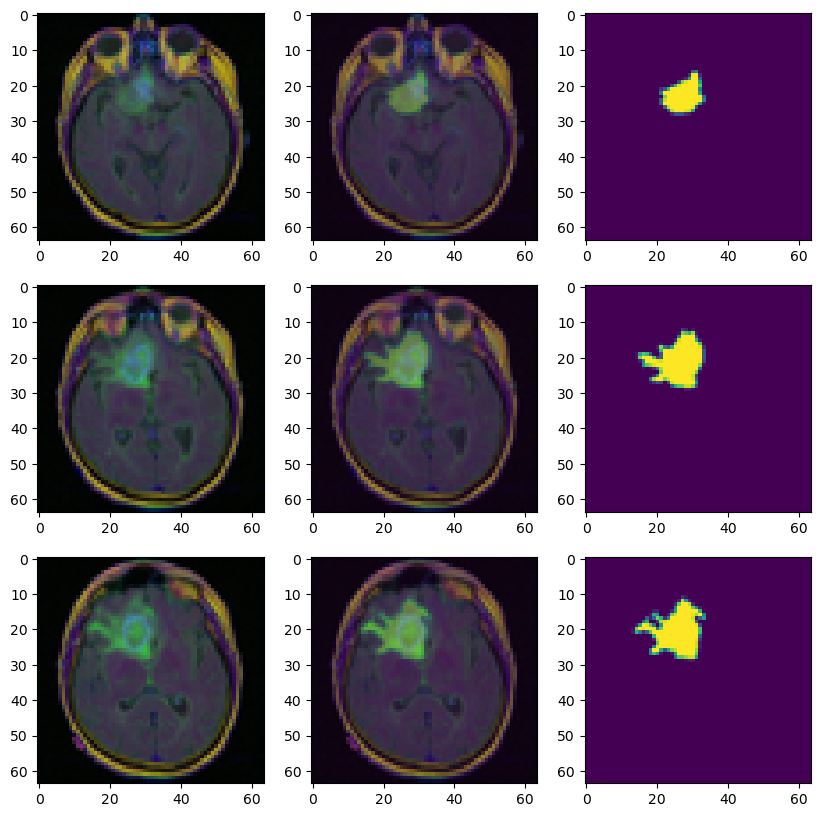

In [7]:
#
# Visualize some samples
#

# You can downlaod the dataset from https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation 
# and save them in your working directory: [curdir]/images/input
currnet_path = os.getcwd()
input_dir = f'{currnet_path}\images\input\lgg-mri-segmentation\kaggle_3m'
input_paths = glob(f'{input_dir}/*/*[0-9].tif')
    
# create data frame
input_file_df = pd.DataFrame([get_data_path(input_path) for input_path in input_paths], columns=['patient_id', 'image_filename', 'mask_filename'])

# resize the image from 256x256 to 64x64
resize = (64, 64)

# view the first 3 images
mridata = MRIDataset(input_file_df[110:130], resize=resize)

fig, ax = plt.subplots(3, 3, figsize=(10, 10))

counter = 0
for index, (i, m) in enumerate(mridata):
    image = Image.open(input_file_df.iloc[index]['image_filename']).resize(resize)
    mask = Image.open(input_file_df.iloc[index]['mask_filename']).resize(resize)
    
    if np.any(mask):        
        # display        
        ax[counter][0].imshow(image)
        ax[counter][1].imshow(image)
        ax[counter][1].imshow(mask, alpha=0.2)
        ax[counter][2].imshow(mask)
        
        counter += 1    
        if counter >= 3:
            break

In [8]:
#
# training loop
#

EPOCHS = 20
BATCH_SIZE = 16 #32
LEARNING_RATE = 0.001
# resize the image from 256x256 to 64x64 to fit my cuda device with 4GB during training
RESIZE = (64, 64)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define model
#
model = Unet(in_channels=3, n_classes=1)
model.to(DEVICE)

# data preprocessing
#
currnet_path = os.getcwd()  # get data paths
input_dir = f'{currnet_path}\images\input\lgg-mri-segmentation\kaggle_3m'
input_paths = glob(f'{input_dir}/*/*[0-9].tif')
    
# create data frame
input_file_df = pd.DataFrame([get_data_path(input_path) for input_path in input_paths], columns=['patient_id', 'image_filename', 'mask_filename'])

# sizes
train_size = int(input_file_df.shape[0] * 0.8)
test_size = input_file_df.shape[0] - train_size

# load data
#
mridata_train = MRIDataset(input_file_df[0:train_size], resize=RESIZE)
mridata_test = MRIDataset(input_file_df[train_size:], resize=RESIZE)

dataloader_train = DataLoader(mridata_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(mridata_test, batch_size=BATCH_SIZE, shuffle=True)

# Optimizer
# 
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Loss function
#
loss_fn = binary_cross_entropy_dice_loss #dice_loss #F.binary_cross_entropy 

accuracies = []
losses = []
eval_losses=[]

x_axis = []
y_axis = []
eval_x_axis = []
eval_y_axis = []
accuracy_x_axis = []
accuracy_y_axis = []

for epoch in range(0, EPOCHS):
    #
    # train
    #
    model.train(True)
    
    for index, (image, mask) in enumerate(tqdm(dataloader_train)):
        # image.shape: 32, 3, 64, 64
        # mask.shape: 32, 1, 64, 64
        
        # image.requires_grad_(True)
        # mask.requires_grad_(True)
        
        pred = model(image.to(DEVICE)) # pred.shape: 32, 1, 64, 64
        
        pred = pred.squeeze(1)
        mask = mask.squeeze(1)
        
        loss = loss_fn(pred, mask.to(DEVICE))
        loss.requires_grad_(True)
        
        optimizer.zero_grad()
        loss.backward()
        
        losses.append(loss.item())
        
        optimizer.step()
        
    x_axis.append(epoch)
    y_axis.append(np.array(losses).mean())
    
    print(f"epoch: {epoch}, loss: {np.array(losses).mean()}")
    
    #
    # validate
    #
    model.eval()
    
    with torch.no_grad():
        for index, (eval_image, eval_mask) in enumerate(tqdm(dataloader_test)):
            eval_pred = model(eval_image.to(DEVICE)) # pred.shape: 32, 1, 64, 64
        
            eval_pred = eval_pred.squeeze(1)
            eval_mask = eval_mask.squeeze(1)

            eval_loss = loss_fn(eval_pred, eval_mask.to(DEVICE))
            eval_losses.append(eval_loss.item())
            
            # use dice coefficient instead of pixel accuracy
            accuracy = dice_coef(eval_pred, eval_mask.to(DEVICE))
            # accuracy = pixel_accuracy(eval_pred, eval_mask.to(DEVICE))
            
            accuracies.append(accuracy.item())
            
        eval_x_axis.append(epoch)
        eval_y_axis.append(np.array(eval_losses).mean())
        
        accuracy_x_axis.append(epoch)
        accuracy_y_axis.append(np.array(accuracies).mean())
        
        print(f"epoch: {epoch}, val loss: {np.array(eval_losses).mean()}, dice coefficient: {np.array(accuracies).mean()}")
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:28<00:00,  6.81it/s]


epoch: 0, loss: 0.1781957408763128


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.72it/s]


epoch: 0, val loss: 0.06661060646176338, dice coefficient: 0.07586122965440154


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:29<00:00,  6.76it/s]


epoch: 1, loss: 0.11037597228503469


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.28it/s]


epoch: 1, val loss: 0.05537828190252185, dice coefficient: 0.08854920498793944


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:29<00:00,  6.58it/s]


epoch: 2, loss: 0.08355201977461123


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.13it/s]


epoch: 2, val loss: 0.049731391854584216, dice coefficient: 0.1037757296099638


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.11it/s]


epoch: 3, loss: 0.06883557693120376


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.68it/s]


epoch: 3, val loss: 0.045854953890666364, dice coefficient: 0.11413953388924711


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:36<00:00,  5.42it/s]


epoch: 4, loss: 0.05945011232766857


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.40it/s]


epoch: 4, val loss: 0.043105338741093874, dice coefficient: 0.12221545111201704


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:30<00:00,  6.53it/s]


epoch: 5, loss: 0.05293821464111483


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.38it/s]


epoch: 5, val loss: 0.04126036561094224, dice coefficient: 0.1287336590094492


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:30<00:00,  6.50it/s]


epoch: 6, loss: 0.04802679137527359


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.46it/s]


epoch: 6, val loss: 0.03920157938663449, dice coefficient: 0.13782055189167813


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:30<00:00,  6.53it/s]


epoch: 7, loss: 0.04423906027485952


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.82it/s]


epoch: 7, val loss: 0.03795187249779701, dice coefficient: 0.14438982050516644


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:30<00:00,  6.46it/s]


epoch: 8, loss: 0.041196092349690905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.45it/s]


epoch: 8, val loss: 0.0367155044981175, dice coefficient: 0.15043045787037246


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:30<00:00,  6.48it/s]


epoch: 9, loss: 0.03867071399956866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.42it/s]


epoch: 9, val loss: 0.03683259464986623, dice coefficient: 0.1516991435319651


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:30<00:00,  6.42it/s]


epoch: 10, loss: 0.036598966490472166


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.38it/s]


epoch: 10, val loss: 0.035857578360221604, dice coefficient: 0.15681748399955475


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.14it/s]


epoch: 11, loss: 0.03485070909814698


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  8.24it/s]


epoch: 11, val loss: 0.03585249088549366, dice coefficient: 0.15780699979921337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:30<00:00,  6.39it/s]


epoch: 12, loss: 0.03333616122779426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.36it/s]


epoch: 12, val loss: 0.03596775085593645, dice coefficient: 0.15913907832627255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:29<00:00,  6.61it/s]


epoch: 13, loss: 0.03199091901870321


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.78it/s]


epoch: 13, val loss: 0.035242256417072244, dice coefficient: 0.16232358165966745


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:29<00:00,  6.76it/s]


epoch: 14, loss: 0.030833730498697552


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.82it/s]


epoch: 14, val loss: 0.03470718113829692, dice coefficient: 0.16521820432770376


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:29<00:00,  6.62it/s]


epoch: 15, loss: 0.029793275450179024


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.01it/s]


epoch: 15, val loss: 0.034202688037185, dice coefficient: 0.1673760712305375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:29<00:00,  6.78it/s]


epoch: 16, loss: 0.028846302170392097


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.04it/s]


epoch: 16, val loss: 0.033885878110852315, dice coefficient: 0.16919515113359976


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:29<00:00,  6.72it/s]


epoch: 17, loss: 0.028024204837781307


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.79it/s]


epoch: 17, val loss: 0.0339919374189857, dice coefficient: 0.16966555391089058


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:29<00:00,  6.69it/s]


epoch: 18, loss: 0.027309237015434855


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.66it/s]


epoch: 18, val loss: 0.03344413752912691, dice coefficient: 0.17212597635026566


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:29<00:00,  6.74it/s]


epoch: 19, loss: 0.02661035245256073


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.94it/s]

epoch: 19, val loss: 0.03286305013298988, dice coefficient: 0.17517089015422568


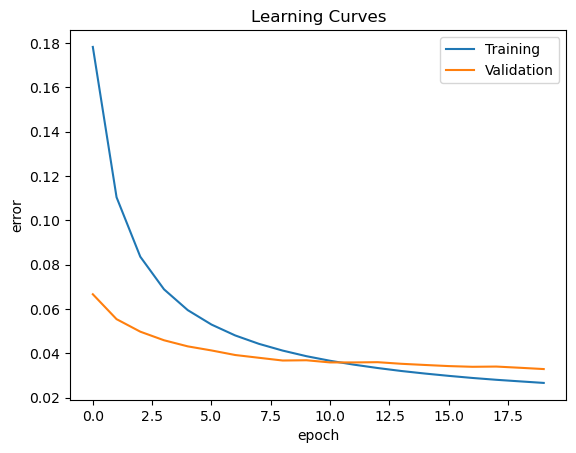

In [9]:
plt.plot(x_axis, y_axis)
plt.plot(eval_x_axis, eval_y_axis)
plt.title('Learning Curves')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend(['Training', 'Validation'])
plt.show()

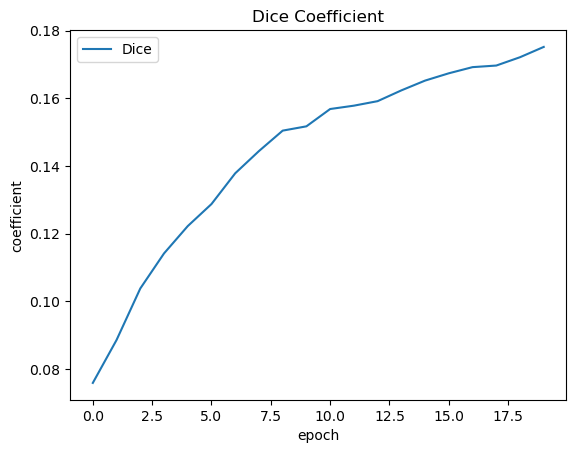

In [10]:
plt.plot(accuracy_x_axis, accuracy_y_axis)
plt.title('Dice Coefficient')
plt.xlabel('epoch')
plt.ylabel('coefficient')
plt.legend(['Dice'])
plt.show()

Pixel Accuracy:  0.9736328125
iou:  0.8676941394805908
dice coefficient:  0.14596712589263916

Pixel Accuracy:  0.985595703125
iou:  0.907031238079071
dice coefficient:  0.07895096391439438

Pixel Accuracy:  0.990966796875
iou:  0.9163798689842224
dice coefficient:  0.14012984931468964

Pixel Accuracy:  0.991943359375
iou:  0.9348056316375732
dice coefficient:  0.07357539981603622

Pixel Accuracy:  0.992919921875
iou:  0.9468845725059509
dice coefficient:  0.08462131768465042



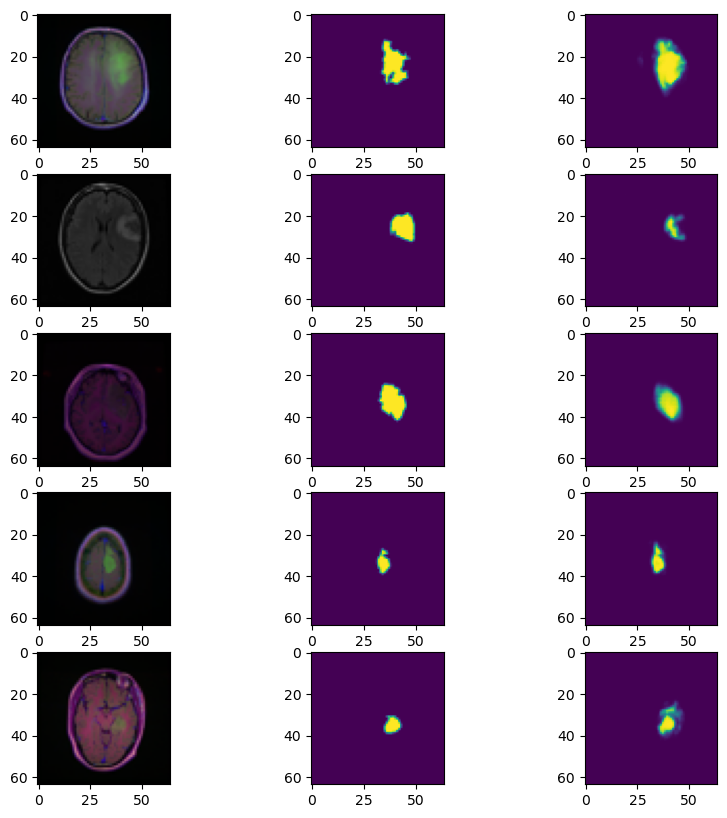

In [11]:
#
# Test the model
#

dataloader_test = DataLoader(mridata_test, batch_size=1, shuffle=True)

counter = 0
with torch.no_grad():
    fig, ax = plt.subplots(5, 3, figsize=(10, 10))
    for index, (image, mask) in enumerate(dataloader_test):
        if np.any(T.ToPILImage()(mask.squeeze(1))):            
            # 
            pred = model(image.to(DEVICE))
            
            ax[counter][0].imshow(T.ToPILImage()(image.squeeze(0)))
            ax[counter][1].imshow(T.ToPILImage()(mask.squeeze(1)))
            ax[counter][2].imshow(T.ToPILImage()(pred.squeeze(1)))
            
            print("Pixel Accuracy: ", pixel_accuracy(pred, mask.to(DEVICE)).item())
            print("iou: ", iou(pred, mask.to(DEVICE)).item())
            print("dice coefficient: ", dice_coef(pred, mask.to(DEVICE)).item())
            print("")
            
            counter += 1    
            if counter >= 5:
                break